In [1]:
# !pip install pycaret
# !pip install waterfallcharts
# !pip install gradio

In [0]:
#VETORES
import pandas as pd
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

#VISUAIS
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = "DejaVu Sans"  

#SKLEARN
from sklearn.preprocessing import MinMaxScaler

#WARNINGS
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import matplotlib.pyplot as plt

#PYSPARK
from pyspark.sql.functions import col

#pycaret
from pycaret.regression import *

In [0]:
CLASS_TO_CODE = {
    'ExtraTreesRegressor': 'et',
    'RandomForestRegressor': 'rf',
    'XGBRegressor': 'xgboost',
    'LGBMRegressor': 'lightgbm',
    'CatBoostRegressor': 'catboost',
    'DecisionTreeRegressor': 'dt',
    'LinearRegression': 'lr',
}


def load_data(path):
  df = spark.table(path)
  return df


def get_data(df, col_interest):
  df = df.toPandas()

  # Apenas onde col_interest > 0
  df_filtered = df[df[col_interest] > 0].copy()

    # Salva a coluna original TIPO
  df_aux = df_filtered[['TIPO']].copy()

  # Mapeia o grupo da campanha e agrupa
  def map_grupo(tipo):
      if tipo in ['MARCA', 'OPORTUNIDADES', 'GENERICA', 'CURSOS']:
          return 'SEARCH'
      elif tipo in ['ASC', 'RMKT', 'LAL']:
          return 'META'
      elif tipo in ['PMAX']:
          return 'PMAX'
      elif tipo in ['DV360']:
          return 'DV360'
      elif tipo in ['DEMAND GEN']:
          return 'DEMAND GEN'
      else:
          return 'OUTROS'
        
  df_aux['TIPO_CAMPANHA'] = df_aux['TIPO'].apply(map_grupo)
  
  # Remove colunas não usadas no modelo
  df_filtered = df_filtered.drop(['DATA','GRUPO'], axis=1)

  return df_filtered, df_aux


def transformer_data(df):
  # filtra as colunas
  categorical_cols = df.select_dtypes(include=['object']).columns
  numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('CPMAT')

  # Label encoding só nas categóricas
  le = LabelEncoder()
  df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

  # Normalização apenas nas contínuas
  scaler = StandardScaler()
  df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

  return df


def get_model(df_filtered):
  df_filtered_aux = df_filtered['TIPO']
  df_filtered = df_filtered.drop(['TIPO'], axis=1)
  setup(df_filtered, target='CPMAT', session_id=42, verbose=False)
  model_obj = compare_models()
  model_class = type(model_obj).__name__
  model_code = CLASS_TO_CODE.get(model_class)
  print(f"\n Melhor modelo: {model_class}")
  print(f"\n Código do modelo: {model_code}")
  if not model_code:
      print("Modelo vencedor não encontrado na lista. Retornando o modelo treinado diretamente.")
      return model_obj
  
  model_winner = create_model(model_code)
  return model_winner, df_filtered_aux


def visualize_model_performance(model_winner):
  plt.rcParams["font.family"] = "DejaVu Sans"
  print("\n\t-> Plotando importância das features:")
  plot_model(model_winner, plot='feature')

  print("\n\t -> Interpretando modelo com SHAP:")
  interpret_model(model_winner)
  return model_winner


def calculate_shap_values(model_winner):
  #dados de treino
  X_train = get_config('X_train')
  y_train = get_config('y_train')

  #dados de teste
  X_test = get_config('X_test')
  y_test = get_config('y_test')

  # dados transformados de teste, usados para treinar
  X_test_transformed = get_config("X_test_transformed")

  # criando o explicador shap
  explainer = shap.Explainer(model_winner, X_test_transformed)

  # gerando os valores shap a para os dados transformados
  shap_values = explainer(X_test_transformed)

  # Prepare a tabela para armazenar os valores
  shap_table = []

  # Itera por cada linha no X_test_transformed
  for i in range(len(X_test_transformed)):
    # Para cada registro, associe os valores SHAP com os valores da feature original
    row_data = {
        "base_value": shap_values.base_values[i],  # Valor base
        "predicted_value": shap_values.values[i].sum() + shap_values.base_values[i],  # Predição via SHAP
    }
    
    # Adiciona os valores SHAP e as variáveis originais
    for j, feature_name in enumerate(X_test_transformed.columns):
      row_data[f"{feature_name}_shap"] = shap_values[i].values[j]

    shap_table.append(row_data)

  # Crie o DataFrame com os valores
  df_shap = pd.DataFrame(shap_table, index=X_test.index)
  
  return X_test, y_test, X_test_transformed, df_shap
  

def plot_shap_waterfall_by_campanha(df_shap_values, campanha_escolhida, limite=150):
    # Remove colunas duplicadas, se existirem
    df_shap_values = df_shap_values.loc[:, ~df_shap_values.columns.duplicated()]

    # Filtra a campanha desejada
    df_filtrado = df_shap_values[df_shap_values['TIPO_CAMPANHA'] == campanha_escolhida]

    # Seleciona apenas as colunas SHAP
    shap_cols = [col for col in df_filtrado.columns if col.endswith('_shap')]

    # Calcula a média dos SHAP values
    mean_shap = df_filtrado[shap_cols].mean()

    # Filtra somente contribuições relevantes (fora do intervalo ±limite)
    mean_shap = mean_shap[(mean_shap > limite) | (mean_shap < -limite)]
    mean_shap = mean_shap.sort_values(key=abs, ascending=False)

    # Valores e rótulos
    labels = mean_shap.index.tolist()
    values = mean_shap.values

    # Valor base e predição média
    base_value = df_filtrado['base_value'].mean()
    prediction = base_value + values.sum()

    # Cores
    colors = ['green' if v > 0 else 'red' for v in values]
    colors.insert(0, 'gray')
    labels.insert(0, 'Base value')
    values = np.insert(values, 0, base_value)

    # Base acumulada
    starts = np.cumsum([0] + list(values[:-1]))

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(len(values)):
        ax.bar(labels[i], values[i], bottom=starts[i], color=colors[i])
        y = starts[i] + values[i]
        va = 'bottom' if values[i] > 0 else 'top'
        offset = 1.5 if values[i] > 0 else -1.5
        ax.text(i, y + offset * 0.01, f"{values[i]:+.2f}", ha='center', va=va, fontsize=8)

    ax.axhline(y=prediction, linestyle='--', color='black', label=f'Predição média: {prediction:.2f}')
    ax.set_ylabel('Contribuição média SHAP')
    ax.set_title(f'SHAP Waterfall - Campanha: {campanha_escolhida}')
    ax.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


def plot_shap_waterfall_percentual_by_campanha2(df_shap_values, campanha_escolhida, limite=150):
    df_shap_values = df_shap_values.loc[:, ~df_shap_values.columns.duplicated()]
    df_filtrado = df_shap_values[df_shap_values['TIPO_CAMPANHA'] == campanha_escolhida]
    shap_cols = [col for col in df_filtrado.columns if col.endswith('_shap')]
    mean_shap = df_filtrado[shap_cols].mean()
    base_value = df_filtrado['base_value'].mean()
    prediction = base_value + mean_shap.sum()
    mean_shap = mean_shap[(mean_shap > limite) | (mean_shap < -limite)]
    mean_shap_pct = (mean_shap / prediction) * 100
    base_value_pct = (base_value / prediction) * 100
    prediction_pct = 100
    mean_shap_pct = mean_shap_pct.sort_values(key=abs, ascending=False)

    labels = mean_shap_pct.index.tolist()
    values = mean_shap_pct.values
    colors = ['green' if v > 0 else 'red' for v in values]
    colors.insert(0, 'gray')
    labels.insert(0, 'Base value')
    values = np.insert(values, 0, base_value_pct)
    starts = np.cumsum([0] + list(values[:-1]))

    fig, ax = plt.subplots(figsize=(12, 6))

    for i in range(len(values)):
        ax.bar(labels[i], values[i], bottom=starts[i], color=colors[i], zorder=3)
        y = starts[i] + values[i]
        va = 'bottom' if values[i] > 0 else 'top'
        offset = 1.5 if values[i] > 0 else -1.5
        ax.text(i, y + offset * 0.5, f"{values[i]:+.2f}%", ha='center', va=va, fontsize=8, zorder=4)

    y_max = max(starts + values) * 1.3  # aumenta espaço topo
    y_min = min(starts + values)*1.2 if min(starts + values)<0 else 0
    ax.set_ylim(bottom=y_min, top=y_max)

    # Linha da predição: desenha só no topo da última barra (última label)
    last_bar_pos = len(values) - 1
    ax.hlines(y=prediction_pct, xmin=last_bar_pos - 0.4, xmax=last_bar_pos + 0.4,
              colors='black', linestyles='--', linewidth=1, alpha=0.7, zorder=1)

    # # Texto da predição fora do gráfico (acima do topo)
    # ax.text(last_bar_pos, y_max * 1.02, f'Predição média: {prediction_pct:.2f}%', 
    #         ha='center', va='bottom', fontsize=9, color='black', zorder=5)

    ax.set_ylabel('Contribuição média SHAP (%)')
    ax.set_title(f'SHAP Waterfall Percentual - Campanha: {campanha_escolhida}')
    # ax.legend([f'Predição média: {prediction_pct:.2f}%'])
    plt.xticks(rotation=90)
    plt.tight_layout()
    # plt.show()

    # Salva imagem no buffer
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight')
    buf.seek(0)
    plt.close(fig)

    # Converte para imagem PIL
    image = Image.open(buf)
    return image

In [0]:
path = 'dev_midiamkt.gold.waterfall'

df_loaded = load_data(path)
df_filtered, df_aux = get_data(df_loaded, 'CPMAT')
df_one = transformer_data(df_filtered)
model_winner, df_filtered_aux = get_model(df_one)
X_test, y_test, X_test_transformed, df_shap_values = calculate_shap_values(model_winner)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,6181.6916,2.492387e+08,13584.5010,0.8729,0.3318,0.2921,0.062
gbr,Gradient Boosting Regressor,6601.8791,2.752243e+08,14436.6094,0.8535,0.3347,0.2968,0.064
rf,Random Forest Regressor,6948.1776,2.867056e+08,14824.0129,0.8482,0.3616,0.3265,0.106
xgboost,Extreme Gradient Boosting,6692.1304,2.852719e+08,15025.0770,0.8322,0.3531,0.2818,0.075
lightgbm,Light Gradient Boosting Machine,7641.3474,3.836457e+08,16064.9757,0.8304,0.4421,0.3683,3.320
huber,Huber Regressor,7772.3239,2.267811e+08,14164.0054,0.8286,0.7209,0.6501,0.017
br,Bayesian Ridge,8769.7536,2.213044e+08,14175.7198,0.8269,0.6936,0.8624,0.015
ridge,Ridge Regression,8823.8337,2.232311e+08,14240.6275,0.8251,0.6851,0.8951,0.010
par,Passive Aggressive Regressor,7927.6393,2.363087e+08,14527.2100,0.8194,0.5843,0.6048,0.017
llar,Lasso Least Angle Regression,9122.3832,2.489890e+08,15286.5415,0.8178,0.6625,0.9215,0.011


Processing:  98%|█████████▊| 79/81 [00:49<00:03,  1.86s/it]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


 Melhor modelo: ExtraTreesRegressor

 Código do modelo: et


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5665.8347,1.663102e+08,12896.1298,0.8386,0.2792,0.2215
1,4271.3344,6.373527e+07,7983.4369,0.9308,0.2152,0.1838
2,10790.1498,1.227585e+09,35036.9110,0.7229,0.3727,0.3206
3,4144.9725,6.720638e+07,8197.9498,0.9633,0.3843,0.3491
4,8210.5547,4.018309e+08,20045.7204,0.8716,0.2430,0.1889
5,7786.0282,2.077208e+08,14412.5236,0.8485,0.2412,0.1964
6,6187.5990,1.102369e+08,10499.3771,0.9306,0.3220,0.2729
7,4076.1705,5.191881e+07,7205.4705,0.8041,0.2761,0.2348
8,4948.6957,6.889958e+07,8300.5771,0.9163,0.4940,0.4826


Processing:  75%|███████▌  | 3/4 [00:00<00:00,  4.59it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
df_shap_values = pd.concat([df_shap_values, df_aux[['TIPO_CAMPANHA']]], axis=1)
df_shap_values.dropna(inplace=True, axis=0)
df_shap_values

,base_value,predicted_value,ETAPA_shap,TOTAL_IMPRESSOES_shap,TOTAL_CLIQUES_shap,TOTAL_CUSTO_shap,TOTAL_SESSAO_shap,TOTAL_INSCRICOES_shap,TOTAL_MATRICULADOS_shap,LEADS_shap,CTR_shap,CR_shap,CPS_shap,TX_LEADS_shap,TX_INSCRITOS_shap,CPI_shap,TX_MATRICULADOS_shap,CPA_shap,TIPO_CAMPANHA
347,28666.789195,14445.722622,856.041172,-5793.967683,-3920.325621,-5977.642081,-4837.789284,-288.880260,2995.754096,-411.865622,295.893482,1216.316162,1324.081915,494.229069,795.338236,1383.529039,-1789.320914,-562.458279,OUTROS
70,28666.789195,37422.560567,131.129130,7293.520861,-2744.765452,348.991306,-4646.883763,-315.004445,5038.789286,-484.305707,-1358.415823,1989.057858,1710.800804,1155.220075,1103.322023,2187.591998,-1632.036535,-1021.240242,DV360
33,28666.789195,2972.177272,-673.718163,-6713.075740,-3689.632582,1947.409977,-4339.740656,-7.102591,-4588.034887,98.526725,46.934434,-1226.932131,427.451219,-1353.144186,-1020.910521,-1274.387471,-2875.531233,-452.724118,SEARCH
559,28666.789195,2803.381512,-293.080096,-6434.321549,-4542.443693,-3918.994759,-4371.594595,136.099573,-1152.333218,175.807730,305.882009,-1368.064316,-247.374386,-397.726448,-611.381073,-1960.265750,-380.916093,-802.701018,OUTROS
109,28666.789195,11228.182852,1052.903264,-5964.656145,-4255.464226,-6847.885138,-4688.955172,-105.655684,2982.460395,-351.183651,181.535400,638.897179,7.572878,625.391709,791.106198,-187.393353,-609.630005,-707.649991,OUTROS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,28666.789195,48972.996129,715.713471,5590.501137,3846.837262,4796.515728,2411.900484,97.400287,2006.281679,176.708940,-2903.929094,-2053.445124,-795.568466,1481.510657,845.768258,1387.687937,383.054771,2319.269008,OUTROS
655,28666.789195,29722.516196,-2342.894095,4601.556324,5573.044177,-9203.606837,3648.070275,-72.860288,3633.063312,-565.156422,-350.902550,-361.721413,-1479.746329,-5.625277,1081.699964,357.999905,-1734.779832,-1722.413912,DEMAND GEN
372,28666.789195,195294.637254,-2317.453979,36828.177252,38433.246705,12814.764092,85000.198140,-468.785216,2179.410298,-299.695528,408.609219,682.592263,-2842.894251,-861.241909,-1003.872601,926.048680,-689.061286,-2162.193821,DEMAND GEN
641,28666.789195,1442.625156,-238.948271,-6714.832694,-4568.135136,-4504.618570,-4473.861862,138.108111,-764.335464,91.406219,215.497531,-1545.355210,-405.346472,-406.358435,-598.712400,-1863.724251,-780.132662,-804.814474,OUTROS


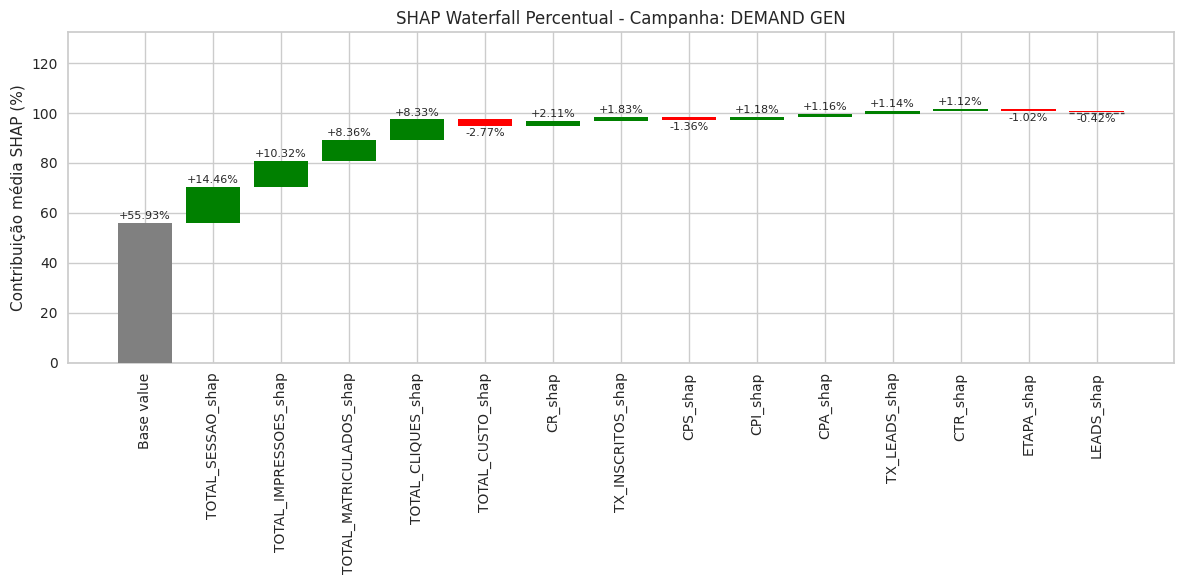

In [0]:
# plot_shap_waterfall_by_campanha(df_shap_values, campanha_escolhida = 'DEMAND GEN', limite=150)
from io import BytesIO
from PIL import Image
plot_shap_waterfall_percentual_by_campanha2(df_shap_values, campanha_escolhida = 'DEMAND GEN', limite=150)

### Interpretação do Valor Base e sua Contribuição Percentual na Predição Média

No gráfico de waterfall baseado em SHAP values, o **valor base** (*base value*) representa a predição média esperada pelo modelo **antes de considerar qualquer informação específica sobre os registros**. Em outras palavras, é o valor que o modelo preveria caso todas as features tivessem um efeito neutro.

Para cada campanha analisada, a **predição média** é obtida somando o valor base às contribuições médias de cada feature, conforme a fórmula:

$$
\text{Predição média} = \text{Valor base} + \sum_{i=1}^{n} \text{SHAP}_i
$$

A proporção que o valor base representa na predição média é expressa da seguinte forma:

$$
\text{Contribuição percentual do valor base} = \left( \frac{\text{Valor base}}{\text{Predição média}} \right) \times 100
$$

Essa métrica permite entender o quanto da predição total é explicada **pela tendência geral do modelo** e o quanto é influenciado pelas características específicas da campanha. Por exemplo, se o valor base representar 80% da predição média, significa que as variáveis explicativas da campanha contribuíram com os 20% restantes, revelando seu impacto efetivo.

Essa abordagem auxilia na transparência da explicação do modelo e facilita a comparação entre diferentes campanhas.



In [0]:
import gradio as gr
from io import BytesIO
import traceback

# Gradio app
campanhas_disponiveis = df_shap_values["TIPO_CAMPANHA"].unique().tolist()
# print(campanhas_disponiveis)

interface = gr.Interface(
    fn=plot_shap_waterfall_percentual_by_campanha2,
    inputs=[
        gr.Dropdown(choices=campanhas_disponiveis, label="Selecione a campanha que quer analisar"),
        gr.Slider(0, 500, value=150, step=10, label="Limite mínimo de SHAP para exibir (%)")
    ],
    outputs=gr.Image(type="pil", label="Gráfico Waterfall SHAP"),
    title="Análise de features por Campanha - WATERFALL",
)

if __name__ == "__main__":
    interface.launch(share=True)

['OUTROS', 'DV360', 'SEARCH', 'DEMAND GEN', 'PMAX']
* Running on local URL:  http://127.0.0.1:7865
* Running on public URL: https://af8828980274a6c053.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
